# **Import necessary libraries**

In [59]:
import pandas as pd
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

import re
import string

# from textblob import TextBlob
# from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.utils import resample

# **Load Data**

In [60]:
df = pd.read_json(f"data//News_Category_Dataset_v3.json",lines = True)
df = df[['headline','short_description','category']]

In [61]:
df

,headline,short_description,category
0,Over 4 Million Americans Roll Up Sleeves For O...,Health experts said it is too early to predict...,U.S. NEWS
1,"American Airlines Flyer Charged, Banned For Li...",He was subdued by passengers and crew when he ...,U.S. NEWS
2,23 Of The Funniest Tweets About Cats And Dogs ...,"""Until you have a dog you don't understand wha...",COMEDY
3,The Funniest Tweets From Parents This Week (Se...,"""Accidentally put grown-up toothpaste on my to...",PARENTING
4,Woman Who Called Cops On Black Bird-Watcher Lo...,Amy Cooper accused investment firm Franklin Te...,U.S. NEWS
...,...,...,...
209522,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,Verizon Wireless and AT&T are already promotin...,TECH
209523,Maria Sharapova Stunned By Victoria Azarenka I...,"Afterward, Azarenka, more effusive with the pr...",SPORTS
209524,"Giants Over Patriots, Jets Over Colts Among M...","Leading up to Super Bowl XLVI, the most talked...",SPORTS
209525,Aldon Smith Arrested: 49ers Linebacker Busted ...,CORRECTION: An earlier version of this story i...,SPORTS


List the unique categories in the dataset

In [62]:
print(df['category'].unique())
print(f"Total Unique Categories: {len(df['category'].unique())}")

['U.S. NEWS' 'COMEDY' 'PARENTING' 'WORLD NEWS' 'CULTURE & ARTS' 'TECH'
 'SPORTS' 'ENTERTAINMENT' 'POLITICS' 'WEIRD NEWS' 'ENVIRONMENT'
 'EDUCATION' 'CRIME' 'SCIENCE' 'WELLNESS' 'BUSINESS' 'STYLE & BEAUTY'
 'FOOD & DRINK' 'MEDIA' 'QUEER VOICES' 'HOME & LIVING' 'WOMEN'
 'BLACK VOICES' 'TRAVEL' 'MONEY' 'RELIGION' 'LATINO VOICES' 'IMPACT'
 'WEDDINGS' 'COLLEGE' 'PARENTS' 'ARTS & CULTURE' 'STYLE' 'GREEN' 'TASTE'
 'HEALTHY LIVING' 'THE WORLDPOST' 'GOOD NEWS' 'WORLDPOST' 'FIFTY' 'ARTS'
 'DIVORCE']
Total Unique Categories: 42


Check if there is any null values in the datasets

In [63]:
df.isnull().any()

headline             False
short_description    False
category             False
dtype: bool

Print the columns of the dataframe

In [64]:
print(df.columns)

Index(['headline', 'short_description', 'category'], dtype='object')


count values based on the category

In [65]:
df['category'].value_counts()

category
POLITICS          35602
WELLNESS          17945
ENTERTAINMENT     17362
TRAVEL             9900
STYLE & BEAUTY     9814
PARENTING          8791
HEALTHY LIVING     6694
QUEER VOICES       6347
FOOD & DRINK       6340
BUSINESS           5992
COMEDY             5400
SPORTS             5077
BLACK VOICES       4583
HOME & LIVING      4320
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3653
WOMEN              3572
CRIME              3562
IMPACT             3484
DIVORCE            3426
WORLD NEWS         3299
MEDIA              2944
WEIRD NEWS         2777
GREEN              2622
WORLDPOST          2579
RELIGION           2577
STYLE              2254
SCIENCE            2206
TECH               2104
TASTE              2096
MONEY              1756
ARTS               1509
ENVIRONMENT        1444
FIFTY              1401
GOOD NEWS          1398
U.S. NEWS          1377
ARTS & CULTURE     1339
COLLEGE            1144
LATINO VOICES      1130
CULTURE & ARTS     1074
EDUCATI

# **Data Preprocessing**

**Select only required categories that will be used**

In [66]:
def category_selection(df):
  category_mapping = {
      'Politics':['Politics'],
      'Wellness':['Wellness'],
      'Entertainment':['Comedy','Entertainment'],
      'Finance':['Business','Money'],
      'Sports':['Sports'],
      'Travel':['Travel'],
      'Style & Beauty':['Style & beauty','Style']
  }
  category_mapping = {value.upper():key for key,values in category_mapping.items() for value in values}
  df['category'] = df['category'].map(category_mapping).fillna('Others')
  df = df[df['category'] != 'Others']
  df = df.reset_index()
  return df

In [67]:
df = category_selection(df)
df

,index,headline,short_description,category
0,2,23 Of The Funniest Tweets About Cats And Dogs ...,"""Until you have a dog you don't understand wha...",Entertainment
1,17,"Maury Wills, Base-Stealing Shortstop For Dodge...","Maury Wills, who helped the Los Angeles Dodger...",Sports
2,20,Golden Globes Returning To NBC In January Afte...,"For the past 18 months, Hollywood has effectiv...",Entertainment
3,21,Biden Says U.S. Forces Would Defend Taiwan If ...,President issues vow as tensions with China rise.,Politics
4,24,‘Beautiful And Sad At The Same Time’: Ukrainia...,An annual celebration took on a different feel...,Politics
...,...,...,...,...
111097,209513,'Girl With the Dragon Tattoo' India Release Ca...,"""Sony Pictures will not be releasing The Girl ...",Entertainment
111098,209523,Maria Sharapova Stunned By Victoria Azarenka I...,"Afterward, Azarenka, more effusive with the pr...",Sports
111099,209524,"Giants Over Patriots, Jets Over Colts Among M...","Leading up to Super Bowl XLVI, the most talked...",Sports
111100,209525,Aldon Smith Arrested: 49ers Linebacker Busted ...,CORRECTION: An earlier version of this story i...,Sports


print unique categories from filtered datasets

In [68]:
df['category'].unique()

array(['Entertainment', 'Sports', 'Politics', 'Wellness', 'Finance',
       'Style & Beauty', 'Travel'], dtype=object)

count the values based on the categories

In [69]:
df['category'].value_counts()

category
Politics          35602
Entertainment     22762
Wellness          17945
Style & Beauty    12068
Travel             9900
Finance            7748
Sports             5077
Name: count, dtype: int64

<Axes: xlabel='category'>

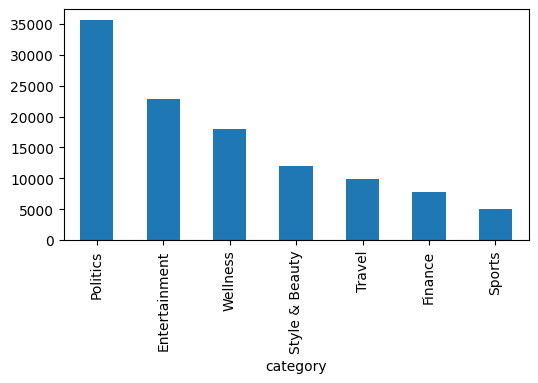

In [70]:
df['category'].value_counts().plot( kind='bar', figsize=(6,3))

In [71]:
categories = df['category'].unique()
balanced_df = []
target_samples = len(df[df['category'] == 'Wellness'])

In [72]:
#resample the dataset to balance the dataset.
for category in categories:
    if category == 'Wellness':
        balanced_df.append(df[df['category'] == 'Wellness'])
    else:
        category_data = df[df['category'] == category]
        category_resampled = resample(category_data,
                                      replace=True,
                                      n_samples=target_samples,
                                      random_state=42)
        balanced_df.append(category_resampled)
df =pd.concat(balanced_df)

In [73]:
#shuffle the dataframe
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df

,index,headline,short_description,category
0,155376,Body Clock Study Offers Clues To Possible Jet ...,(Reporting by Kate Kelland; Editing by Sonya H...,Wellness
1,85267,Uber Could Be World's Most Valuable Start-Up I...,Just three months after raising an enormous su...,Finance
2,66040,The Golden State Warriors Just Splashed Their ...,And naturally it was Curry who led the way.,Sports
3,150831,How To Wear Stackable Rings Without Looking Li...,And the best thing about this trend? You proba...,Style & Beauty
4,139874,Tools for Fighting Prostate Cancer,By providing a nutrient-rich environment via o...,Wellness
...,...,...,...,...
125610,14792,6 Breathtaking Destinations With No Cell Servi...,"1. Hacienda AltaGracia (Pérez Zeledón, Costa R...",Travel
125611,194478,"Anna Wintour Takes In Wimbledon Matches, Smile...",So what does the ruler of the fashion world we...,Style & Beauty
125612,82535,"Diddy Trades Birthday Cake For Apple Pie, Like...",Party with pie. 🙌,Entertainment
125613,126046,"Yes, You Can Cancel Cable And Still Keep HBO",,Entertainment


In [74]:
df['category'].value_counts()

category
Wellness          17945
Finance           17945
Sports            17945
Style & Beauty    17945
Entertainment     17945
Politics          17945
Travel            17945
Name: count, dtype: int64

<Axes: xlabel='category'>

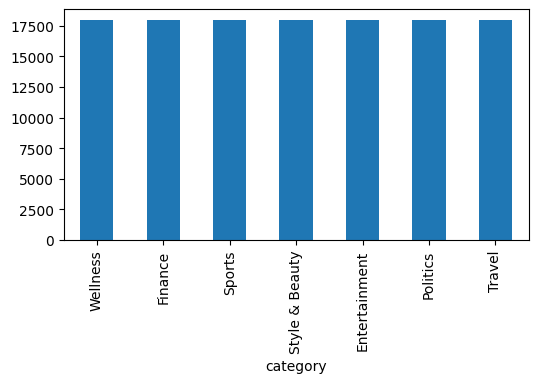

In [75]:
df['category'].value_counts().plot( kind='bar', figsize=(6,3))

In [76]:
df = df.rename(columns = {'short_description':'text'})
df['text'] = df['headline'] + " " + df['text']
df

,index,headline,text,category
0,155376,Body Clock Study Offers Clues To Possible Jet ...,Body Clock Study Offers Clues To Possible Jet ...,Wellness
1,85267,Uber Could Be World's Most Valuable Start-Up I...,Uber Could Be World's Most Valuable Start-Up I...,Finance
2,66040,The Golden State Warriors Just Splashed Their ...,The Golden State Warriors Just Splashed Their ...,Sports
3,150831,How To Wear Stackable Rings Without Looking Li...,How To Wear Stackable Rings Without Looking Li...,Style & Beauty
4,139874,Tools for Fighting Prostate Cancer,Tools for Fighting Prostate Cancer By providin...,Wellness
...,...,...,...,...
125610,14792,6 Breathtaking Destinations With No Cell Servi...,6 Breathtaking Destinations With No Cell Servi...,Travel
125611,194478,"Anna Wintour Takes In Wimbledon Matches, Smile...","Anna Wintour Takes In Wimbledon Matches, Smile...",Style & Beauty
125612,82535,"Diddy Trades Birthday Cake For Apple Pie, Like...","Diddy Trades Birthday Cake For Apple Pie, Like...",Entertainment
125613,126046,"Yes, You Can Cancel Cable And Still Keep HBO","Yes, You Can Cancel Cable And Still Keep HBO",Entertainment


In [77]:
# import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')

clean,tokenize,remove stop word

In [78]:
stop_words = set(stopwords.words('english'))  #generate set of stopwords
wn = WordNetLemmatizer()  #used to lemmatize the word(convert word into its base form)
punc = list(string.punctuation) #generate the list of punctuation symbol

def validate_text(token):
  return  token not in stop_words and token not in punc  and len(token)>2

def clean_text(text):
  text = text.lower()
  clean_text = []
  text = re.sub("'","",text)
  text = re.sub(r"(\d|\W)+", " ", text)
  for word in word_tokenize(text):
    if validate_text(word):
      lematized_word = wn.lemmatize(word,pos = "v")
      clean_text.append(lematized_word)
  return " ".join(clean_text)


In [79]:
df['cleaned_text'] = df['text'].apply(clean_text)
df


,index,headline,text,category,cleaned_text
0,155376,Body Clock Study Offers Clues To Possible Jet ...,Body Clock Study Offers Clues To Possible Jet ...,Wellness,body clock study offer clue possible jet lag c...
1,85267,Uber Could Be World's Most Valuable Start-Up I...,Uber Could Be World's Most Valuable Start-Up I...,Finance,uber could worlds valuable start billion fund ...
2,66040,The Golden State Warriors Just Splashed Their ...,The Golden State Warriors Just Splashed Their ...,Sports,golden state warriors splash way nba finals na...
3,150831,How To Wear Stackable Rings Without Looking Li...,How To Wear Stackable Rings Without Looking Li...,Style & Beauty,wear stackable ring without look like best thi...
4,139874,Tools for Fighting Prostate Cancer,Tools for Fighting Prostate Cancer By providin...,Wellness,tool fight prostate cancer provide nutrient ri...
...,...,...,...,...,...
125610,14792,6 Breathtaking Destinations With No Cell Servi...,6 Breathtaking Destinations With No Cell Servi...,Travel,breathtaking destinations cell service next va...
125611,194478,"Anna Wintour Takes In Wimbledon Matches, Smile...","Anna Wintour Takes In Wimbledon Matches, Smile...",Style & Beauty,anna wintour take wimbledon match smile photos...
125612,82535,"Diddy Trades Birthday Cake For Apple Pie, Like...","Diddy Trades Birthday Cake For Apple Pie, Like...",Entertainment,diddy trade birthday cake apple pie like boss ...
125613,126046,"Yes, You Can Cancel Cable And Still Keep HBO","Yes, You Can Cancel Cable And Still Keep HBO",Entertainment,yes cancel cable still keep hbo


In [80]:
df = df[df['cleaned_text'] != '']
df

,index,headline,text,category,cleaned_text
0,155376,Body Clock Study Offers Clues To Possible Jet ...,Body Clock Study Offers Clues To Possible Jet ...,Wellness,body clock study offer clue possible jet lag c...
1,85267,Uber Could Be World's Most Valuable Start-Up I...,Uber Could Be World's Most Valuable Start-Up I...,Finance,uber could worlds valuable start billion fund ...
2,66040,The Golden State Warriors Just Splashed Their ...,The Golden State Warriors Just Splashed Their ...,Sports,golden state warriors splash way nba finals na...
3,150831,How To Wear Stackable Rings Without Looking Li...,How To Wear Stackable Rings Without Looking Li...,Style & Beauty,wear stackable ring without look like best thi...
4,139874,Tools for Fighting Prostate Cancer,Tools for Fighting Prostate Cancer By providin...,Wellness,tool fight prostate cancer provide nutrient ri...
...,...,...,...,...,...
125610,14792,6 Breathtaking Destinations With No Cell Servi...,6 Breathtaking Destinations With No Cell Servi...,Travel,breathtaking destinations cell service next va...
125611,194478,"Anna Wintour Takes In Wimbledon Matches, Smile...","Anna Wintour Takes In Wimbledon Matches, Smile...",Style & Beauty,anna wintour take wimbledon match smile photos...
125612,82535,"Diddy Trades Birthday Cake For Apple Pie, Like...","Diddy Trades Birthday Cake For Apple Pie, Like...",Entertainment,diddy trade birthday cake apple pie like boss ...
125613,126046,"Yes, You Can Cancel Cable And Still Keep HBO","Yes, You Can Cancel Cable And Still Keep HBO",Entertainment,yes cancel cable still keep hbo


create some new varaible that can be used as additional feature to improve the quality of the classifier

In [81]:
# def calculate_polarity_subjectivity(text):
#   blob = TextBlob(text).sentiment
#   polarity = blob[0]
#   subjectivity = blob[1]
#   return polarity,subjectivity

# def text_len(text):
#   if len(text.split()) > 0:
#     return len(text.split())
#   else:
#     return 0

# df['Polarity'],df['Subjectivity'] = zip(*df['text'].apply(calculate_polarity_subjectivity))
# df['Text Length'] = df['text'].apply(text_len)
# df

In [82]:
# df.loc[:, 'text'] = df['cleaned_text']  #replce text column with cleaned_text column
# df = df[['text','Polarity','Subjectivity','Text Length','category']]
# df

In [83]:
df['category'].unique()

array(['Wellness', 'Finance', 'Sports', 'Style & Beauty', 'Entertainment',
       'Politics', 'Travel'], dtype=object)

In [84]:
df['category'].value_counts(ascending = False)

category
Wellness          17945
Sports            17945
Style & Beauty    17945
Finance           17944
Politics          17944
Travel            17944
Entertainment     17940
Name: count, dtype: int64

In [85]:
# df['Subjectivity'].min()

In [86]:
# df['Polarity'].max()

In [87]:
# import matplotlib.pyplot as plt
# politics = df[df['category'] == 'Politics']
# poltics = politics['text']
# text_combined = ' '.join(poltics)

# # Generate word cloud
# wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(text_combined)

# # Display the generated word cloud
# plt.figure(figsize=(10, 5))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.show()


In [88]:
# X = df[['text','Polarity','Subjectivity','Text Length']]
X = df['text']
y= df['category']

In [89]:
X

0         Body Clock Study Offers Clues To Possible Jet ...
1         Uber Could Be World's Most Valuable Start-Up I...
2         The Golden State Warriors Just Splashed Their ...
3         How To Wear Stackable Rings Without Looking Li...
4         Tools for Fighting Prostate Cancer By providin...
                                ...                        
125610    6 Breathtaking Destinations With No Cell Servi...
125611    Anna Wintour Takes In Wimbledon Matches, Smile...
125612    Diddy Trades Birthday Cake For Apple Pie, Like...
125613        Yes, You Can Cancel Cable And Still Keep HBO 
125614    Route 66, Ride for the Relay, Day 10 Just one ...
Name: text, Length: 125607, dtype: object

In [90]:
y

0               Wellness
1                Finance
2                 Sports
3         Style & Beauty
4               Wellness
               ...      
125610            Travel
125611    Style & Beauty
125612     Entertainment
125613     Entertainment
125614            Travel
Name: category, Length: 125607, dtype: object

In [91]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3, random_state = 0, shuffle = True)

In [92]:
print(f"X_train.shape: {X_train.shape}\nX_test.shape: {X_test.shape}\ny_train.shape: {y_train.shape}\ny_test.shape: {y_test.shape}")

X_train.shape: (87924,)
X_test.shape: (37683,)
y_train.shape: (87924,)
y_test.shape: (37683,)


In [93]:
# Step 2: Text Vectorization
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# # Step 3: Feature Scaling
# scaler = StandardScaler()
# X_train_numeric = scaler.fit_transform(X_train[['Polarity', 'Subjectivity', 'Text Length']])
# X_test_numeric = scaler.transform(X_test[['Polarity', 'Subjectivity', 'Text Length']])

# # Combine text features and numeric features
# import scipy.sparse as sp
# X_train_final = sp.hstack((X_train_text_features, X_train_numeric), format='csr')
# X_test_final = sp.hstack((X_test_text_features, X_test_numeric), format='csr')

In [94]:
print(type(X_train_vectorized))

<class 'scipy.sparse._csr.csr_matrix'>


In [95]:
logistic_reg = LogisticRegression(multi_class = 'ovr',max_iter = 1000)
# model = OneVsRestClassifier(logistic_reg)
model = logistic_reg

In [96]:
model.fit(X_train_vectorized, y_train)

LogisticRegression(max_iter=1000, multi_class='ovr')

In [97]:
y_pred = model.predict(X_test_vectorized)
print(y_pred)

['Finance' 'Finance' 'Travel' ... 'Entertainment' 'Finance'
 'Style & Beauty']


In [98]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Get classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9185839768595918
Classification Report:
                precision    recall  f1-score   support

 Entertainment       0.88      0.88      0.88      5318
       Finance       0.89      0.92      0.90      5346
      Politics       0.91      0.89      0.90      5358
        Sports       0.95      0.98      0.97      5385
Style & Beauty       0.94      0.93      0.93      5353
        Travel       0.94      0.95      0.95      5494
      Wellness       0.92      0.88      0.90      5429

      accuracy                           0.92     37683
     macro avg       0.92      0.92      0.92     37683
  weighted avg       0.92      0.92      0.92     37683



In [99]:
# test_text = "Contrary to the claim of the Pushpa Kamal Dahal-led government and the ruling parties that the ongoing session of Parliament would be effective, the meeting of the House of Representatives on Thursday was adjourned without entering the agenda for the lack of quorum."
# test_text = "Urmila Matondkar recalls shooting romantic song with Shah Rukh Khan from their film 'Chamatkar'"
# test_text = "The recent rally in global stocks has only a little further to go given last year's unexpectedly sharp run-up, according to a Reuters poll of equity strategists who were evenly split on whether there will be a correction in the next three months."
# test_text = "Keeping up a solid morning skin care routine is a key to achieving healthy skin. And of course, your skin’s needs change as you age, requiring different products and routines. How you treat your skin in the morning affects you throughout the day, protecting against pollution and harmful UV rays. (Your nighttime routine, on the other hand, includes more actives to heal the skin overnight.)"
# test_text = "A mountainous roadway full of ever-changing seasonal scenery and sumptuous curves landed its usual No. 1 spot as the most visited site in the US National Park system and accounts for 5.15% of all visits in the system."
# test_text = "“Understand that fitness is your goal. Begin with something that you enjoy building momentum. It can be an hour of playing badminton or a walk"
# test_text = "Nepal suffered back-to-back defeat against Namibia in Nepal Tri-series of the ICC Cricket World Cup League 2 (2024-2027) after the Rhinos fell to a two-wicket loss at the TU Cricket Ground in Kirtipur on Wednesday."
# test_text = "Any infrastructures built in the national park areas and forests should be wildlife-friendly. However, this notion was completely ignored while building the embankment on the Rapti river near the eastern sector office of the Chitwan National Park. The area is frequented by the endangered one-horned rhinoceros and gharials, among other animals."
# test_text = "Registrar at the Patan High Court Man Bahadur Karki has confirmed that Lamichhane registered an appeal against the Kathmandu District Court’s verdict on Thursday, and the court allowed him to appeal remaining out of jail."
test_text=" The actor, who was last seen in 'Badla', is currently working on Ayan Mukherji's 'Brahmastra' and a bilingual project, titled 'Tera Yaar Hoon Main'. Bachchan is also teaming up with Emraan Hashmi for a mystery thriller."
cleaned_text = clean_text(test_text)
print(cleaned_text)

actor last see badla currently work ayan mukherjis brahmastra bilingual project title tera yaar hoon main bachchan also team emraan hashmi mystery thriller


In [100]:
input_vect = vectorizer.transform([cleaned_text])
# Make prediction using the trained model
prediction = model.predict(input_vect)

# Print the prediction
print("Predicted category:", prediction[0])

Predicted category: Entertainment


In [101]:
import pickle
with open('data/model.pkl', 'wb') as f:
    pickle.dump((model, vectorizer), f)